<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [0]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

In [2]:
!wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
!chmod +x ya.py
!python ya.py https://yadi.sk/d/b4nAwIE73TVcp5 ./data
!tar -xvzf handout.tar.gz

--2018-11-19 17:49:31--  https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723 [text/plain]
Saving to: ‘ya.py.3’

ya.py.3             100%[===================>]     723  --.-KB/s    in 0s      

2018-11-19 17:49:31 (72.6 MB/s) - ‘ya.py.3’ saved [723/723]

--2018-11-19 17:49:36--  https://downloader.disk.yandex.ru/disk/98074bbdfbb2e690f7d9c488bb7d646645104e16c4fc005a27024bd765448ea0/5bf32fef/DhLO1VNSy6snhnvOdCmJUQpOrnvzVyH6A1IiV2iZCUU76_UUl5pPzIQOpVDjxIW7s-YjC4J275z-pPZcrln5TQ%3D%3D?uid=0&filename=handout.tar.gz&disposition=attachment&hash=77EpanMA6/IF6XClv8taTY8twF0dR1IwU6SkVE7e6uY%3D%3A&limit=0&content_type=application%2Fgzip&fsize=884

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

### Data preprocessing

In [4]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 290 ms, sys: 695 ms, total: 985 ms
Wall time: 988 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [5]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [0]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [0]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for img in captions:
    for caption in img:
        for word in caption:
            word_counts[word] += 1

In [0]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [0]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out[0])
        
        return logits        

In [13]:
network = CaptionNet(n_tokens)
network.cuda()

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [14]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048)).cuda()
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0]))).cuda()

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = -torch.gather(F.log_softmax(logits_for_next, -1), dim=2, index=captions_ix_next[:,:,None]).mean()
    return loss

In [0]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [0]:
opt = torch.optim.Adam(network.parameters(), lr=0.5)

# Training

* First implement the batch generator
* Than train the network as usual

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return Variable(torch.FloatTensor(batch_images)).cuda(), Variable(torch.LongTensor(batch_captions_ix)).cuda()
    

In [20]:
generate_batch(img_codes,captions,3)

(tensor([[0.6469, 0.3241, 0.3546,  ..., 0.2416, 0.4384, 0.3482],
         [0.4034, 0.1034, 0.3536,  ..., 0.1103, 0.2494, 0.1028],
         [0.4566, 0.4821, 0.5888,  ..., 0.0485, 1.3762, 0.5481]],
        device='cuda:0'),
 tensor([[   1,   88, 1085, 1086, 1590,   18,   45,  201,   18,   24,  372,  373,
            12,    2,    3,    3,    3,    3],
         [   1,   24,  102,   14,  895,  204,   15,   24,  504,  304,  590,  209,
            35,   24,  720,  250,   12,    2],
         [   1,   24,  115,  262,  951,  123,   15,   45,  102,   41,  301,  163,
          9218,   14,   45, 1243,  262,    2]], device='cuda:0'))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [0]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [0]:
from tqdm import tqdm

def train(network, opt, train_img_codes, train_captions, n_epochs=100, batch_size=50, n_batches_per_epoch=50, n_validation_batches=5):
    for epoch in range(n_epochs):

        train_loss=0
        network.train(True)
        for _ in tqdm(range(n_batches_per_epoch)):

            loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


            # clear old gradients; do a backward pass to get new gradients; then train with opt
            loss_t.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss_t.data.cpu().numpy()

        train_loss /= n_batches_per_epoch

        val_loss=0
        network.train(False)
        for _ in range(n_validation_batches):
            loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
            val_loss += loss_t.data.cpu().numpy()
        val_loss /= n_validation_batches

        print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    print("Finished!")

In [23]:
train(network, opt, train_img_codes, train_captions)

 10%|█         | 5/50 [00:00<00:01, 44.04it/s]


Epoch: 0, train loss: 17.325432834625243, val loss: 18.140621757507326


 10%|█         | 5/50 [00:00<00:01, 41.72it/s]


Epoch: 1, train loss: 17.988731727600097, val loss: 15.76825122833252


  8%|▊         | 4/50 [00:00<00:01, 38.21it/s]


Epoch: 2, train loss: 18.46082040786743, val loss: 17.9259313583374


 10%|█         | 5/50 [00:00<00:01, 42.62it/s]


Epoch: 3, train loss: 18.909722805023193, val loss: 17.73443737030029


  8%|▊         | 4/50 [00:00<00:01, 39.63it/s]


Epoch: 4, train loss: 18.83177806854248, val loss: 18.943789672851562


 10%|█         | 5/50 [00:00<00:01, 42.29it/s]


Epoch: 5, train loss: 19.052546768188478, val loss: 18.038014602661132


 10%|█         | 5/50 [00:00<00:01, 42.26it/s]


Epoch: 6, train loss: 18.415158157348632, val loss: 21.140858459472657


  8%|▊         | 4/50 [00:00<00:01, 36.54it/s]


Epoch: 7, train loss: 20.292167835235595, val loss: 17.99125099182129


 10%|█         | 5/50 [00:00<00:01, 41.24it/s]


Epoch: 8, train loss: 18.08991720199585, val loss: 15.793314552307129


 10%|█         | 5/50 [00:00<00:01, 40.33it/s]


Epoch: 9, train loss: 18.90555532455444, val loss: 17.855297088623047


 10%|█         | 5/50 [00:00<00:01, 42.78it/s]


Epoch: 10, train loss: 18.00733865737915, val loss: 17.654003715515138


 10%|█         | 5/50 [00:00<00:01, 43.95it/s]


Epoch: 11, train loss: 19.54670944213867, val loss: 19.706663131713867


  8%|▊         | 4/50 [00:00<00:01, 37.51it/s]


Epoch: 12, train loss: 20.30513553619385, val loss: 16.921373176574708


 10%|█         | 5/50 [00:00<00:01, 40.95it/s]


Epoch: 13, train loss: 20.99788370132446, val loss: 20.67843074798584


  8%|▊         | 4/50 [00:00<00:01, 37.06it/s]


Epoch: 14, train loss: 21.48944772720337, val loss: 22.677458572387696


  8%|▊         | 4/50 [00:00<00:01, 37.67it/s]


Epoch: 15, train loss: 21.852164478302, val loss: 22.944045639038087


 10%|█         | 5/50 [00:00<00:01, 43.25it/s]


Epoch: 16, train loss: 22.748585910797118, val loss: 22.747681427001954


  8%|▊         | 4/50 [00:00<00:01, 37.92it/s]


Epoch: 17, train loss: 22.56549793243408, val loss: 19.30778102874756


 10%|█         | 5/50 [00:00<00:01, 42.48it/s]


Epoch: 18, train loss: 21.261600246429442, val loss: 19.822732543945314


  8%|▊         | 4/50 [00:00<00:01, 37.50it/s]


Epoch: 19, train loss: 21.59151851654053, val loss: 20.469508743286134


 10%|█         | 5/50 [00:00<00:01, 41.99it/s]


Epoch: 20, train loss: 21.12212282180786, val loss: 22.155405807495118


 10%|█         | 5/50 [00:00<00:01, 42.86it/s]


Epoch: 21, train loss: 22.001308765411377, val loss: 20.124213790893556


 10%|█         | 5/50 [00:00<00:01, 40.43it/s]


Epoch: 22, train loss: 22.765529689788817, val loss: 23.0728702545166


  8%|▊         | 4/50 [00:00<00:01, 38.68it/s]


Epoch: 23, train loss: 20.479487628936766, val loss: 19.065777587890626


  8%|▊         | 4/50 [00:00<00:01, 38.95it/s]


Epoch: 24, train loss: 21.42948320388794, val loss: 22.307268142700195


  8%|▊         | 4/50 [00:00<00:01, 39.75it/s]


Epoch: 25, train loss: 22.153694725036623, val loss: 21.185040092468263


  8%|▊         | 4/50 [00:00<00:01, 32.02it/s]


Epoch: 26, train loss: 22.437881240844728, val loss: 24.598987579345703


  8%|▊         | 4/50 [00:00<00:01, 35.35it/s]


Epoch: 27, train loss: 21.90443229675293, val loss: 23.019605255126955


 10%|█         | 5/50 [00:00<00:01, 34.90it/s]


Epoch: 28, train loss: 21.568574829101564, val loss: 23.359498977661133


 10%|█         | 5/50 [00:00<00:01, 41.96it/s]


Epoch: 29, train loss: 21.532806491851808, val loss: 21.31003074645996


  8%|▊         | 4/50 [00:00<00:01, 37.57it/s]


Epoch: 30, train loss: 21.144952373504637, val loss: 20.078005218505858


  8%|▊         | 4/50 [00:00<00:01, 39.31it/s]


Epoch: 31, train loss: 22.73724811553955, val loss: 22.4100772857666


 10%|█         | 5/50 [00:00<00:01, 41.37it/s]


Epoch: 32, train loss: 22.315295696258545, val loss: 20.491888809204102


 10%|█         | 5/50 [00:00<00:01, 38.76it/s]


Epoch: 33, train loss: 23.69651550292969, val loss: 21.083794784545898


 10%|█         | 5/50 [00:00<00:01, 43.33it/s]


Epoch: 34, train loss: 23.51887279510498, val loss: 22.885285949707033


 10%|█         | 5/50 [00:00<00:01, 43.13it/s]


Epoch: 35, train loss: 24.0800545501709, val loss: 24.51510353088379


 10%|█         | 5/50 [00:00<00:01, 44.34it/s]


Epoch: 36, train loss: 21.90034454345703, val loss: 25.741925048828126


  8%|▊         | 4/50 [00:00<00:01, 37.73it/s]


Epoch: 37, train loss: 22.66297233581543, val loss: 23.458951568603517


  8%|▊         | 4/50 [00:00<00:01, 38.23it/s]


Epoch: 38, train loss: 21.34268472671509, val loss: 20.80760097503662


  8%|▊         | 4/50 [00:00<00:01, 36.28it/s]


Epoch: 39, train loss: 22.317788505554198, val loss: 23.256714630126954


 10%|█         | 5/50 [00:00<00:01, 39.85it/s]


Epoch: 40, train loss: 21.68335042953491, val loss: 19.610974502563476


 10%|█         | 5/50 [00:00<00:01, 42.80it/s]


Epoch: 41, train loss: 21.308214645385743, val loss: 22.43556785583496


 10%|█         | 5/50 [00:00<00:01, 43.05it/s]


Epoch: 42, train loss: 23.01566011428833, val loss: 21.815932846069337


  8%|▊         | 4/50 [00:00<00:01, 37.36it/s]


Epoch: 43, train loss: 22.81510856628418, val loss: 23.190646362304687


  8%|▊         | 4/50 [00:00<00:01, 38.20it/s]


Epoch: 44, train loss: 22.29885316848755, val loss: 22.77820930480957


  8%|▊         | 4/50 [00:00<00:01, 39.42it/s]


Epoch: 45, train loss: 22.15281057357788, val loss: 18.1256254196167


  8%|▊         | 4/50 [00:00<00:01, 38.12it/s]


Epoch: 46, train loss: 22.13584394454956, val loss: 20.895737075805663


  8%|▊         | 4/50 [00:00<00:01, 38.05it/s]


Epoch: 47, train loss: 22.311935443878173, val loss: 25.36958465576172


  8%|▊         | 4/50 [00:00<00:01, 39.43it/s]


Epoch: 48, train loss: 21.324472389221192, val loss: 23.698397064208983


 10%|█         | 5/50 [00:00<00:01, 40.53it/s]


Epoch: 49, train loss: 22.32651334762573, val loss: 26.438197708129884


 10%|█         | 5/50 [00:00<00:01, 42.26it/s]


Epoch: 50, train loss: 22.09460542678833, val loss: 21.032472991943358


  6%|▌         | 3/50 [00:00<00:01, 28.26it/s]


Epoch: 51, train loss: 22.756696739196776, val loss: 22.895373153686524


  6%|▌         | 3/50 [00:00<00:01, 28.25it/s]


Epoch: 52, train loss: 21.76276433944702, val loss: 27.30858383178711


  8%|▊         | 4/50 [00:00<00:01, 36.34it/s]


Epoch: 53, train loss: 22.098069229125976, val loss: 21.818954086303712


 10%|█         | 5/50 [00:00<00:01, 41.44it/s]


Epoch: 54, train loss: 21.513522205352782, val loss: 23.52408218383789


 10%|█         | 5/50 [00:00<00:01, 37.44it/s]


Epoch: 55, train loss: 22.000877933502196, val loss: 24.23312454223633


  8%|▊         | 4/50 [00:00<00:01, 34.51it/s]


Epoch: 56, train loss: 23.22446435928345, val loss: 25.289311790466307


 10%|█         | 5/50 [00:00<00:01, 42.17it/s]


Epoch: 57, train loss: 22.936864490509034, val loss: 22.402381134033202


 10%|█         | 5/50 [00:00<00:01, 42.48it/s]


Epoch: 58, train loss: 23.319674282073976, val loss: 26.483132934570314


 10%|█         | 5/50 [00:00<00:01, 40.43it/s]


Epoch: 59, train loss: 24.269368476867676, val loss: 20.733491516113283


  8%|▊         | 4/50 [00:00<00:01, 39.08it/s]


Epoch: 60, train loss: 22.125732326507567, val loss: 24.57052345275879


 10%|█         | 5/50 [00:00<00:01, 43.11it/s]


Epoch: 61, train loss: 21.135795803070067, val loss: 21.91289939880371


  8%|▊         | 4/50 [00:00<00:01, 39.16it/s]


Epoch: 62, train loss: 21.208144817352295, val loss: 22.974453735351563


 10%|█         | 5/50 [00:00<00:01, 44.11it/s]


Epoch: 63, train loss: 22.644726066589357, val loss: 22.186632347106933


  8%|▊         | 4/50 [00:00<00:01, 38.41it/s]


Epoch: 64, train loss: 21.72224355697632, val loss: 22.821778106689454


 10%|█         | 5/50 [00:00<00:01, 42.69it/s]


Epoch: 65, train loss: 21.619553833007814, val loss: 25.957737350463866


  8%|▊         | 4/50 [00:00<00:01, 39.96it/s]


Epoch: 66, train loss: 22.834476947784424, val loss: 22.77564811706543


  8%|▊         | 4/50 [00:00<00:01, 39.69it/s]


Epoch: 67, train loss: 22.55009059906006, val loss: 22.564146423339842


 10%|█         | 5/50 [00:00<00:01, 44.17it/s]


Epoch: 68, train loss: 21.684065647125244, val loss: 18.613917922973634


 10%|█         | 5/50 [00:00<00:01, 37.00it/s]


Epoch: 69, train loss: 22.19968854904175, val loss: 21.82799072265625


 10%|█         | 5/50 [00:00<00:01, 41.52it/s]


Epoch: 70, train loss: 21.554469718933106, val loss: 19.35195255279541


  8%|▊         | 4/50 [00:00<00:01, 39.77it/s]


Epoch: 71, train loss: 21.203987979888915, val loss: 24.001834106445312


  8%|▊         | 4/50 [00:00<00:01, 34.63it/s]


Epoch: 72, train loss: 22.034895668029787, val loss: 21.727785491943358


 10%|█         | 5/50 [00:00<00:01, 41.06it/s]


Epoch: 73, train loss: 21.5584051322937, val loss: 22.805739974975587


  8%|▊         | 4/50 [00:00<00:01, 39.34it/s]


Epoch: 74, train loss: 23.031991996765136, val loss: 22.778355407714844


  8%|▊         | 4/50 [00:00<00:01, 36.12it/s]


Epoch: 75, train loss: 21.683138999938965, val loss: 18.474378967285155


 10%|█         | 5/50 [00:00<00:01, 40.87it/s]


Epoch: 76, train loss: 22.61872570037842, val loss: 23.333768844604492


 10%|█         | 5/50 [00:00<00:01, 41.04it/s]


Epoch: 77, train loss: 22.26200666427612, val loss: 21.770063591003417


 10%|█         | 5/50 [00:00<00:01, 41.21it/s]


Epoch: 78, train loss: 22.969832401275635, val loss: 21.516364288330077


  8%|▊         | 4/50 [00:00<00:01, 38.74it/s]


Epoch: 79, train loss: 23.17780782699585, val loss: 23.46894950866699


  8%|▊         | 4/50 [00:00<00:01, 33.90it/s]


Epoch: 80, train loss: 22.05589641571045, val loss: 21.98696804046631


 10%|█         | 5/50 [00:00<00:01, 42.10it/s]


Epoch: 81, train loss: 21.95682434082031, val loss: 18.031091499328614


  8%|▊         | 4/50 [00:00<00:01, 38.60it/s]


Epoch: 82, train loss: 21.26026082992554, val loss: 19.85906410217285


 10%|█         | 5/50 [00:00<00:01, 41.91it/s]


Epoch: 83, train loss: 21.8596639251709, val loss: 18.267023658752443


 10%|█         | 5/50 [00:00<00:01, 43.64it/s]


Epoch: 84, train loss: 21.425226192474366, val loss: 22.276229858398438


 10%|█         | 5/50 [00:00<00:01, 40.18it/s]


Epoch: 85, train loss: 22.118270206451417, val loss: 21.753667068481445


  8%|▊         | 4/50 [00:00<00:01, 37.36it/s]


Epoch: 86, train loss: 21.900804195404053, val loss: 22.22730484008789


  8%|▊         | 4/50 [00:00<00:01, 38.68it/s]


Epoch: 87, train loss: 20.873732070922852, val loss: 20.96809501647949


 10%|█         | 5/50 [00:00<00:01, 41.44it/s]


Epoch: 88, train loss: 22.43264991760254, val loss: 24.839491653442384


 10%|█         | 5/50 [00:00<00:01, 41.26it/s]


Epoch: 89, train loss: 23.228393783569334, val loss: 24.087137603759764


 10%|█         | 5/50 [00:00<00:01, 40.94it/s]


Epoch: 90, train loss: 23.593336200714113, val loss: 25.966440200805664


  8%|▊         | 4/50 [00:00<00:01, 39.86it/s]


Epoch: 91, train loss: 22.58277177810669, val loss: 25.516618728637695


 10%|█         | 5/50 [00:00<00:01, 42.81it/s]


Epoch: 92, train loss: 21.728847312927247, val loss: 24.289861297607423


  8%|▊         | 4/50 [00:00<00:01, 38.65it/s]


Epoch: 93, train loss: 22.6863698387146, val loss: 25.637850189208983


  8%|▊         | 4/50 [00:00<00:01, 39.53it/s]


Epoch: 94, train loss: 22.42582160949707, val loss: 24.205723190307616


 10%|█         | 5/50 [00:00<00:01, 42.65it/s]


Epoch: 95, train loss: 20.8448486328125, val loss: 21.72624855041504


  8%|▊         | 4/50 [00:00<00:01, 31.03it/s]


Epoch: 96, train loss: 19.911934585571288, val loss: 21.340340232849123


 10%|█         | 5/50 [00:00<00:01, 40.75it/s]


Epoch: 97, train loss: 22.647251071929933, val loss: 23.806133270263672


  8%|▊         | 4/50 [00:00<00:01, 37.17it/s]


Epoch: 98, train loss: 23.061637420654296, val loss: 23.571390533447264


100%|██████████| 50/50 [00:01<00:00, 38.46it/s]


Epoch: 99, train loss: 21.479063415527342, val loss: 21.87108631134033
Finished!


In [24]:
network = CaptionNet(n_tokens)
network.cuda()

opt = torch.optim.Adagrad(network.parameters(), lr=0.5)

train(network, opt, train_img_codes, train_captions)

 10%|█         | 5/50 [00:00<00:00, 45.78it/s]


Epoch: 0, train loss: 8.404416275024413, val loss: 4.530476093292236


  8%|▊         | 4/50 [00:00<00:01, 39.76it/s]


Epoch: 1, train loss: 4.176098327636719, val loss: 3.573719310760498


 10%|█         | 5/50 [00:00<00:01, 41.63it/s]


Epoch: 2, train loss: 3.618172519207001, val loss: 3.334175205230713


  8%|▊         | 4/50 [00:00<00:01, 35.33it/s]


Epoch: 3, train loss: 3.260520191192627, val loss: 3.2307701587677


 10%|█         | 5/50 [00:00<00:01, 38.96it/s]


Epoch: 4, train loss: 3.111043016910553, val loss: 2.8195369720458983


 10%|█         | 5/50 [00:00<00:01, 43.03it/s]


Epoch: 5, train loss: 3.0319016432762145, val loss: 2.391715335845947


  8%|▊         | 4/50 [00:00<00:01, 36.94it/s]


Epoch: 6, train loss: 2.8791613936424256, val loss: 2.6655750274658203


  8%|▊         | 4/50 [00:00<00:01, 38.96it/s]


Epoch: 7, train loss: 2.945891103744507, val loss: 3.0600603580474854


 10%|█         | 5/50 [00:00<00:01, 41.97it/s]


Epoch: 8, train loss: 2.8073524761199953, val loss: 3.4468022346496583


  8%|▊         | 4/50 [00:00<00:01, 34.70it/s]


Epoch: 9, train loss: 2.748156328201294, val loss: 3.0157923698425293


 10%|█         | 5/50 [00:00<00:00, 45.72it/s]


Epoch: 10, train loss: 2.649250931739807, val loss: 3.0156254291534426


 10%|█         | 5/50 [00:00<00:01, 43.81it/s]


Epoch: 11, train loss: 2.730896224975586, val loss: 2.682186222076416


 10%|█         | 5/50 [00:00<00:01, 43.36it/s]


Epoch: 12, train loss: 2.717026948928833, val loss: 2.592371416091919


  8%|▊         | 4/50 [00:00<00:01, 37.66it/s]


Epoch: 13, train loss: 2.629916923046112, val loss: 2.588389849662781


 10%|█         | 5/50 [00:00<00:01, 41.93it/s]


Epoch: 14, train loss: 2.5890768814086913, val loss: 2.4155290603637694


 10%|█         | 5/50 [00:00<00:01, 42.08it/s]


Epoch: 15, train loss: 2.6836015439033507, val loss: 2.6185748100280763


 10%|█         | 5/50 [00:00<00:01, 42.73it/s]


Epoch: 16, train loss: 2.506654984951019, val loss: 2.5264974355697634


  8%|▊         | 4/50 [00:00<00:01, 39.91it/s]


Epoch: 17, train loss: 2.58703066110611, val loss: 2.2520184755325316


 10%|█         | 5/50 [00:00<00:01, 43.23it/s]


Epoch: 18, train loss: 2.5268990087509153, val loss: 2.270779776573181


 10%|█         | 5/50 [00:00<00:01, 44.00it/s]


Epoch: 19, train loss: 2.475194787979126, val loss: 2.4066763401031492


  8%|▊         | 4/50 [00:00<00:01, 33.29it/s]


Epoch: 20, train loss: 2.4687059187889098, val loss: 2.414374828338623


 10%|█         | 5/50 [00:00<00:01, 41.35it/s]


Epoch: 21, train loss: 2.4810561633110044, val loss: 2.9094350337982178


 10%|█         | 5/50 [00:00<00:01, 42.49it/s]


Epoch: 22, train loss: 2.491294810771942, val loss: 2.471232843399048


 10%|█         | 5/50 [00:00<00:01, 42.74it/s]


Epoch: 23, train loss: 2.5055899620056152, val loss: 2.1212881565093995


 10%|█         | 5/50 [00:00<00:00, 46.05it/s]


Epoch: 24, train loss: 2.41588130235672, val loss: 2.4085073471069336


 10%|█         | 5/50 [00:00<00:01, 43.12it/s]


Epoch: 25, train loss: 2.4720750713348387, val loss: 2.030080723762512


 10%|█         | 5/50 [00:00<00:01, 44.04it/s]


Epoch: 26, train loss: 2.4222708916664124, val loss: 2.36353862285614


  8%|▊         | 4/50 [00:00<00:01, 37.93it/s]


Epoch: 27, train loss: 2.4108064150810242, val loss: 2.723380136489868


  8%|▊         | 4/50 [00:00<00:01, 38.91it/s]


Epoch: 28, train loss: 2.4233801770210266, val loss: 2.4042304039001463


 10%|█         | 5/50 [00:00<00:01, 42.97it/s]


Epoch: 29, train loss: 2.3036450266838076, val loss: 1.7952218055725098


  8%|▊         | 4/50 [00:00<00:01, 39.34it/s]


Epoch: 30, train loss: 2.4448590207099916, val loss: 2.6499073982238768


 10%|█         | 5/50 [00:00<00:01, 41.12it/s]


Epoch: 31, train loss: 2.2741452741622923, val loss: 2.5696155548095705


 10%|█         | 5/50 [00:00<00:01, 41.12it/s]


Epoch: 32, train loss: 2.344673368930817, val loss: 2.3671023845672607


 10%|█         | 5/50 [00:00<00:01, 42.79it/s]


Epoch: 33, train loss: 2.379785716533661, val loss: 2.7027870178222657


 10%|█         | 5/50 [00:00<00:01, 42.76it/s]


Epoch: 34, train loss: 2.327893249988556, val loss: 2.3891096830368044


 10%|█         | 5/50 [00:00<00:01, 42.34it/s]


Epoch: 35, train loss: 2.350937588214874, val loss: 2.648724842071533


 10%|█         | 5/50 [00:00<00:01, 44.03it/s]


Epoch: 36, train loss: 2.2705415511131286, val loss: 2.3054897785186768


  8%|▊         | 4/50 [00:00<00:01, 38.43it/s]


Epoch: 37, train loss: 2.3554958045482635, val loss: 2.4726762771606445


  8%|▊         | 4/50 [00:00<00:01, 39.31it/s]


Epoch: 38, train loss: 2.4232302021980288, val loss: 2.221121382713318


 10%|█         | 5/50 [00:00<00:00, 45.43it/s]


Epoch: 39, train loss: 2.2818191039562223, val loss: 2.36636905670166


  8%|▊         | 4/50 [00:00<00:01, 34.69it/s]


Epoch: 40, train loss: 2.2909832072257994, val loss: 2.3051048040390016


  8%|▊         | 4/50 [00:00<00:01, 38.78it/s]


Epoch: 41, train loss: 2.2237436413764953, val loss: 2.3676590442657472


  8%|▊         | 4/50 [00:00<00:01, 37.49it/s]


Epoch: 42, train loss: 2.2127884078025817, val loss: 2.1188579559326173


 10%|█         | 5/50 [00:00<00:00, 47.04it/s]


Epoch: 43, train loss: 2.2723809456825257, val loss: 2.4097241401672362


  8%|▊         | 4/50 [00:00<00:01, 37.65it/s]


Epoch: 44, train loss: 2.391437816619873, val loss: 1.9657453298568726


  8%|▊         | 4/50 [00:00<00:01, 34.57it/s]


Epoch: 45, train loss: 2.4662475037574767, val loss: 2.698602390289307


 10%|█         | 5/50 [00:00<00:01, 44.79it/s]


Epoch: 46, train loss: 2.131323320865631, val loss: 2.0058319330215455


 10%|█         | 5/50 [00:00<00:01, 41.14it/s]


Epoch: 47, train loss: 2.384435839653015, val loss: 2.1377483367919923


 10%|█         | 5/50 [00:00<00:00, 48.06it/s]


Epoch: 48, train loss: 2.333768651485443, val loss: 2.069169616699219


 10%|█         | 5/50 [00:00<00:01, 42.84it/s]


Epoch: 49, train loss: 2.288210414648056, val loss: 2.1316941738128663


 10%|█         | 5/50 [00:00<00:01, 44.34it/s]


Epoch: 50, train loss: 2.320015320777893, val loss: 2.2343934535980225


 10%|█         | 5/50 [00:00<00:01, 42.15it/s]


Epoch: 51, train loss: 2.1997775292396544, val loss: 2.0057980537414553


  8%|▊         | 4/50 [00:00<00:01, 34.94it/s]


Epoch: 52, train loss: 2.2055599761009215, val loss: 1.9000361204147338


 10%|█         | 5/50 [00:00<00:00, 45.83it/s]


Epoch: 53, train loss: 2.298969202041626, val loss: 2.2718598365783693


  8%|▊         | 4/50 [00:00<00:01, 39.88it/s]


Epoch: 54, train loss: 2.2343754148483277, val loss: 2.336096096038818


  8%|▊         | 4/50 [00:00<00:01, 36.09it/s]


Epoch: 55, train loss: 2.2256489825248718, val loss: 2.331857705116272


 10%|█         | 5/50 [00:00<00:00, 47.71it/s]


Epoch: 56, train loss: 2.280473289489746, val loss: 2.5199998378753663


 10%|█         | 5/50 [00:00<00:01, 41.95it/s]


Epoch: 57, train loss: 2.1927889227867126, val loss: 2.222771644592285


 10%|█         | 5/50 [00:00<00:01, 42.69it/s]


Epoch: 58, train loss: 2.2398892760276796, val loss: 2.600116014480591


 10%|█         | 5/50 [00:00<00:01, 41.57it/s]


Epoch: 59, train loss: 2.228129299879074, val loss: 2.1067185401916504


  8%|▊         | 4/50 [00:00<00:01, 38.05it/s]


Epoch: 60, train loss: 2.2345141267776487, val loss: 2.3424159049987794


 10%|█         | 5/50 [00:00<00:01, 44.21it/s]


Epoch: 61, train loss: 2.196167514324188, val loss: 2.150573420524597


 10%|█         | 5/50 [00:00<00:00, 46.20it/s]


Epoch: 62, train loss: 2.271054482460022, val loss: 2.5899853229522707


 10%|█         | 5/50 [00:00<00:01, 40.38it/s]


Epoch: 63, train loss: 2.30337975025177, val loss: 2.3012317180633546


 10%|█         | 5/50 [00:00<00:00, 45.12it/s]


Epoch: 64, train loss: 2.18662433385849, val loss: 2.492839813232422


 10%|█         | 5/50 [00:00<00:00, 46.49it/s]


Epoch: 65, train loss: 2.134381229877472, val loss: 2.2100764751434325


  8%|▊         | 4/50 [00:00<00:01, 35.46it/s]


Epoch: 66, train loss: 2.2738538575172424, val loss: 2.1669036388397216


 10%|█         | 5/50 [00:00<00:01, 43.03it/s]


Epoch: 67, train loss: 2.149483597278595, val loss: 1.8838704586029054


 10%|█         | 5/50 [00:00<00:01, 43.30it/s]


Epoch: 68, train loss: 2.1636165285110476, val loss: 2.4905813694000245


 10%|█         | 5/50 [00:00<00:01, 44.51it/s]


Epoch: 69, train loss: 2.116801232099533, val loss: 2.4423622131347655


 10%|█         | 5/50 [00:00<00:00, 46.69it/s]


Epoch: 70, train loss: 2.248390727043152, val loss: 2.1677929878234865


 10%|█         | 5/50 [00:00<00:01, 39.93it/s]


Epoch: 71, train loss: 2.076172436475754, val loss: 2.037602353096008


 10%|█         | 5/50 [00:00<00:01, 43.84it/s]


Epoch: 72, train loss: 2.1046852803230287, val loss: 2.604394006729126


 10%|█         | 5/50 [00:00<00:01, 42.86it/s]


Epoch: 73, train loss: 2.2776849007606508, val loss: 2.186448907852173


  8%|▊         | 4/50 [00:00<00:01, 38.51it/s]


Epoch: 74, train loss: 2.103928225040436, val loss: 2.031927704811096


 10%|█         | 5/50 [00:00<00:01, 43.23it/s]


Epoch: 75, train loss: 2.1882718801498413, val loss: 2.362587642669678


 10%|█         | 5/50 [00:00<00:01, 41.43it/s]


Epoch: 76, train loss: 2.163485543727875, val loss: 2.5061980962753294


 10%|█         | 5/50 [00:00<00:01, 43.27it/s]


Epoch: 77, train loss: 2.1529012227058413, val loss: 2.223071646690369


  8%|▊         | 4/50 [00:00<00:01, 37.25it/s]


Epoch: 78, train loss: 2.139384171962738, val loss: 1.9623583793640136


  8%|▊         | 4/50 [00:00<00:01, 34.40it/s]


Epoch: 79, train loss: 2.1630624103546143, val loss: 1.9892954587936402


 10%|█         | 5/50 [00:00<00:01, 43.83it/s]


Epoch: 80, train loss: 2.1673349142074585, val loss: 3.1108547687530517


  8%|▊         | 4/50 [00:00<00:01, 36.98it/s]


Epoch: 81, train loss: 2.1341575813293456, val loss: 2.099177861213684


 10%|█         | 5/50 [00:00<00:01, 41.62it/s]


Epoch: 82, train loss: 2.1557501935958863, val loss: 2.2124032497406008


 10%|█         | 5/50 [00:00<00:01, 41.35it/s]


Epoch: 83, train loss: 2.1583178758621218, val loss: 2.5000694751739503


 10%|█         | 5/50 [00:00<00:01, 42.96it/s]


Epoch: 84, train loss: 2.0997388911247254, val loss: 2.0386569261550904


 10%|█         | 5/50 [00:00<00:01, 39.80it/s]


Epoch: 85, train loss: 2.076390668153763, val loss: 2.29825119972229


 10%|█         | 5/50 [00:00<00:01, 42.96it/s]


Epoch: 86, train loss: 2.169775629043579, val loss: 2.6055420875549316


 10%|█         | 5/50 [00:00<00:01, 44.19it/s]


Epoch: 87, train loss: 2.1704422402381898, val loss: 2.0444031238555906


 10%|█         | 5/50 [00:00<00:01, 44.72it/s]


Epoch: 88, train loss: 2.087991962432861, val loss: 2.2088687658309936


 10%|█         | 5/50 [00:00<00:01, 41.23it/s]


Epoch: 89, train loss: 2.147009935379028, val loss: 2.4882862091064455


 10%|█         | 5/50 [00:00<00:01, 41.85it/s]


Epoch: 90, train loss: 2.1494664978981017, val loss: 2.2312922716140746


 10%|█         | 5/50 [00:00<00:01, 36.02it/s]


Epoch: 91, train loss: 2.0393076741695406, val loss: 2.0188871383666993


 10%|█         | 5/50 [00:00<00:00, 45.43it/s]


Epoch: 92, train loss: 2.1601734030246735, val loss: 2.343224310874939


 10%|█         | 5/50 [00:00<00:01, 41.09it/s]


Epoch: 93, train loss: 2.1715041518211367, val loss: 2.1808469533920287


 10%|█         | 5/50 [00:00<00:01, 43.34it/s]


Epoch: 94, train loss: 2.0393202972412108, val loss: 2.2816820621490477


 10%|█         | 5/50 [00:00<00:01, 42.10it/s]


Epoch: 95, train loss: 2.1463632345199586, val loss: 2.194360542297363


 10%|█         | 5/50 [00:00<00:00, 45.13it/s]


Epoch: 96, train loss: 2.081819224357605, val loss: 2.4007342576980593


 10%|█         | 5/50 [00:00<00:01, 41.85it/s]


Epoch: 97, train loss: 2.1289633202552793, val loss: 2.5745635509490965


  8%|▊         | 4/50 [00:00<00:01, 39.15it/s]


Epoch: 98, train loss: 2.0172761487960815, val loss: 2.314286231994629


100%|██████████| 50/50 [00:01<00:00, 41.09it/s]



Epoch: 99, train loss: 2.0982494068145754, val loss: 2.513527250289917
Finished!


In [25]:
network = CaptionNet(n_tokens)
network.cuda()

opt = torch.optim.Adadelta(network.parameters(), lr=0.5)

train(network, opt, train_img_codes, train_captions)

  8%|▊         | 4/50 [00:00<00:01, 35.96it/s]


Epoch: 0, train loss: 5.007212972640991, val loss: 3.7794325828552244


  8%|▊         | 4/50 [00:00<00:01, 31.85it/s]


Epoch: 1, train loss: 3.217331576347351, val loss: 2.6455341815948485


  8%|▊         | 4/50 [00:00<00:01, 37.46it/s]


Epoch: 2, train loss: 3.0854485297203063, val loss: 2.9669983863830565


  8%|▊         | 4/50 [00:00<00:01, 38.92it/s]


Epoch: 3, train loss: 2.7634023213386536, val loss: 2.6304052829742433


  8%|▊         | 4/50 [00:00<00:01, 30.90it/s]


Epoch: 4, train loss: 2.8010247945785522, val loss: 3.178526592254639


 10%|█         | 5/50 [00:00<00:01, 41.29it/s]


Epoch: 5, train loss: 2.8179183125495912, val loss: 2.642597770690918


  8%|▊         | 4/50 [00:00<00:01, 37.36it/s]


Epoch: 6, train loss: 2.7541256189346313, val loss: 3.0627145767211914


  8%|▊         | 4/50 [00:00<00:01, 38.10it/s]


Epoch: 7, train loss: 2.6834273529052735, val loss: 2.6630675315856935


  8%|▊         | 4/50 [00:00<00:01, 37.81it/s]


Epoch: 8, train loss: 2.441220746040344, val loss: 2.69409122467041


  8%|▊         | 4/50 [00:00<00:01, 39.05it/s]


Epoch: 9, train loss: 2.5368837571144103, val loss: 2.811572265625


  8%|▊         | 4/50 [00:00<00:01, 36.46it/s]


Epoch: 10, train loss: 2.556329529285431, val loss: 2.3768371105194093


 10%|█         | 5/50 [00:00<00:01, 40.65it/s]


Epoch: 11, train loss: 2.5938389039039613, val loss: 2.835683727264404


  8%|▊         | 4/50 [00:00<00:01, 37.74it/s]


Epoch: 12, train loss: 2.5140198159217833, val loss: 2.8228179931640627


  8%|▊         | 4/50 [00:00<00:01, 36.25it/s]


Epoch: 13, train loss: 2.5783813214302063, val loss: 2.3309603691101075


  8%|▊         | 4/50 [00:00<00:01, 39.76it/s]


Epoch: 14, train loss: 2.443229284286499, val loss: 2.591009759902954


  8%|▊         | 4/50 [00:00<00:01, 37.97it/s]


Epoch: 15, train loss: 2.4716743803024293, val loss: 2.8138172149658205


  8%|▊         | 4/50 [00:00<00:01, 34.32it/s]


Epoch: 16, train loss: 2.512421545982361, val loss: 2.1355674505233764


  8%|▊         | 4/50 [00:00<00:01, 36.74it/s]


Epoch: 17, train loss: 2.4970254826545717, val loss: 2.4526687383651735


 10%|█         | 5/50 [00:00<00:01, 40.49it/s]


Epoch: 18, train loss: 2.403028457164764, val loss: 2.2511703729629517


  8%|▊         | 4/50 [00:00<00:01, 38.75it/s]


Epoch: 19, train loss: 2.409942054748535, val loss: 2.5862220287323


  8%|▊         | 4/50 [00:00<00:01, 39.57it/s]


Epoch: 20, train loss: 2.4973955750465393, val loss: 2.452863669395447


  8%|▊         | 4/50 [00:00<00:01, 35.67it/s]


Epoch: 21, train loss: 2.35842325925827, val loss: 2.0260892152786254


  8%|▊         | 4/50 [00:00<00:01, 36.72it/s]


Epoch: 22, train loss: 2.3121655106544496, val loss: 2.446599006652832


  8%|▊         | 4/50 [00:00<00:01, 36.01it/s]


Epoch: 23, train loss: 2.432534875869751, val loss: 1.9726549625396728


  8%|▊         | 4/50 [00:00<00:01, 32.53it/s]


Epoch: 24, train loss: 2.2730279684066774, val loss: 2.518030118942261


  8%|▊         | 4/50 [00:00<00:01, 37.66it/s]


Epoch: 25, train loss: 2.32003999710083, val loss: 2.364844250679016


  8%|▊         | 4/50 [00:00<00:01, 38.25it/s]


Epoch: 26, train loss: 2.3069572830200196, val loss: 2.5954326152801515


  8%|▊         | 4/50 [00:00<00:01, 37.55it/s]


Epoch: 27, train loss: 2.335510218143463, val loss: 2.201827955245972


 10%|█         | 5/50 [00:00<00:01, 40.69it/s]


Epoch: 28, train loss: 2.2982053399085998, val loss: 2.170016813278198


  8%|▊         | 4/50 [00:00<00:01, 36.56it/s]


Epoch: 29, train loss: 2.299283046722412, val loss: 2.5209391832351686


  8%|▊         | 4/50 [00:00<00:01, 38.77it/s]


Epoch: 30, train loss: 2.38300567150116, val loss: 2.511400842666626


  8%|▊         | 4/50 [00:00<00:01, 38.65it/s]


Epoch: 31, train loss: 2.3067424404621124, val loss: 2.5117210865020754


  8%|▊         | 4/50 [00:00<00:01, 38.04it/s]


Epoch: 32, train loss: 2.2726658725738527, val loss: 2.4743221759796143


  8%|▊         | 4/50 [00:00<00:01, 37.85it/s]


Epoch: 33, train loss: 2.2915808391571044, val loss: 2.4056097984313967


  8%|▊         | 4/50 [00:00<00:01, 32.62it/s]


Epoch: 34, train loss: 2.267948262691498, val loss: 2.031876564025879


  8%|▊         | 4/50 [00:00<00:01, 38.14it/s]


Epoch: 35, train loss: 2.244880292415619, val loss: 2.1891703844070434


  8%|▊         | 4/50 [00:00<00:01, 38.57it/s]


Epoch: 36, train loss: 2.233224484920502, val loss: 2.122040295600891


 10%|█         | 5/50 [00:00<00:01, 39.84it/s]


Epoch: 37, train loss: 2.285771789550781, val loss: 2.295898747444153


  6%|▌         | 3/50 [00:00<00:01, 29.73it/s]


Epoch: 38, train loss: 2.1031247568130493, val loss: 2.0695674896240233


  8%|▊         | 4/50 [00:00<00:01, 38.94it/s]


Epoch: 39, train loss: 2.166512138843536, val loss: 2.3295338630676268


  8%|▊         | 4/50 [00:00<00:01, 32.12it/s]


Epoch: 40, train loss: 2.2509190392494203, val loss: 2.1831281661987303


  8%|▊         | 4/50 [00:00<00:01, 35.13it/s]


Epoch: 41, train loss: 2.2236856245994567, val loss: 2.1249820709228517


  8%|▊         | 4/50 [00:00<00:01, 35.59it/s]


Epoch: 42, train loss: 2.1728360533714293, val loss: 2.2372012615203856


  8%|▊         | 4/50 [00:00<00:01, 39.24it/s]


Epoch: 43, train loss: 2.232185473442078, val loss: 2.212819314002991


  8%|▊         | 4/50 [00:00<00:01, 32.97it/s]


Epoch: 44, train loss: 2.1671714186668396, val loss: 2.366621398925781


  8%|▊         | 4/50 [00:00<00:01, 33.60it/s]


Epoch: 45, train loss: 2.164373700618744, val loss: 2.084053564071655


  8%|▊         | 4/50 [00:00<00:01, 34.49it/s]


Epoch: 46, train loss: 2.0992545676231384, val loss: 2.0329855918884276


  8%|▊         | 4/50 [00:00<00:01, 38.82it/s]


Epoch: 47, train loss: 2.14542062997818, val loss: 2.2329434394836425


  8%|▊         | 4/50 [00:00<00:01, 37.20it/s]


Epoch: 48, train loss: 2.1398086190223693, val loss: 2.0515215158462525


  8%|▊         | 4/50 [00:00<00:01, 37.81it/s]


Epoch: 49, train loss: 2.1644720220565796, val loss: 2.0496102571487427


  8%|▊         | 4/50 [00:00<00:01, 37.73it/s]


Epoch: 50, train loss: 2.0864224529266355, val loss: 2.09193217754364


  8%|▊         | 4/50 [00:00<00:01, 38.57it/s]


Epoch: 51, train loss: 2.1171740770339964, val loss: 1.7510192155838014


  8%|▊         | 4/50 [00:00<00:01, 39.01it/s]


Epoch: 52, train loss: 2.2177368450164794, val loss: 2.293554401397705


  8%|▊         | 4/50 [00:00<00:01, 39.81it/s]


Epoch: 53, train loss: 2.155598931312561, val loss: 1.7878727197647095


  8%|▊         | 4/50 [00:00<00:01, 33.14it/s]


Epoch: 54, train loss: 2.1296191811561584, val loss: 2.0792595982551574


  8%|▊         | 4/50 [00:00<00:01, 36.41it/s]


Epoch: 55, train loss: 2.075336971282959, val loss: 1.8983241319656372


  8%|▊         | 4/50 [00:00<00:01, 34.11it/s]


Epoch: 56, train loss: 2.075478456020355, val loss: 1.6615807294845581


  8%|▊         | 4/50 [00:00<00:01, 39.74it/s]


Epoch: 57, train loss: 2.062154381275177, val loss: 2.250013732910156


  8%|▊         | 4/50 [00:00<00:01, 36.81it/s]


Epoch: 58, train loss: 2.1565220522880555, val loss: 1.892002487182617


  8%|▊         | 4/50 [00:00<00:01, 37.70it/s]


Epoch: 59, train loss: 2.0345102524757386, val loss: 1.75568368434906


  8%|▊         | 4/50 [00:00<00:01, 38.68it/s]


Epoch: 60, train loss: 2.0903558039665224, val loss: 2.305753469467163


  8%|▊         | 4/50 [00:00<00:01, 35.73it/s]


Epoch: 61, train loss: 2.0099973678588867, val loss: 1.851233172416687


  8%|▊         | 4/50 [00:00<00:01, 38.02it/s]


Epoch: 62, train loss: 2.075508625507355, val loss: 2.095007848739624


 10%|█         | 5/50 [00:00<00:01, 40.61it/s]


Epoch: 63, train loss: 2.072815487384796, val loss: 2.0723463535308837


  8%|▊         | 4/50 [00:00<00:01, 35.02it/s]


Epoch: 64, train loss: 2.098890495300293, val loss: 2.0208365678787232


  8%|▊         | 4/50 [00:00<00:01, 38.21it/s]


Epoch: 65, train loss: 2.0093784666061403, val loss: 1.9206800699234008


  8%|▊         | 4/50 [00:00<00:01, 39.96it/s]


Epoch: 66, train loss: 2.1306714725494387, val loss: 1.7614418268203735


  8%|▊         | 4/50 [00:00<00:01, 34.13it/s]


Epoch: 67, train loss: 2.0227298963069917, val loss: 1.6931021690368653


  8%|▊         | 4/50 [00:00<00:01, 34.99it/s]


Epoch: 68, train loss: 2.0248215627670287, val loss: 1.8325801610946655


 10%|█         | 5/50 [00:00<00:01, 40.27it/s]


Epoch: 69, train loss: 2.01842688202858, val loss: 1.7588451385498047


  8%|▊         | 4/50 [00:00<00:01, 39.98it/s]


Epoch: 70, train loss: 2.0503209614753723, val loss: 2.262241339683533


  8%|▊         | 4/50 [00:00<00:01, 37.68it/s]


Epoch: 71, train loss: 2.01703453540802, val loss: 2.0265702486038206


  8%|▊         | 4/50 [00:00<00:01, 36.71it/s]


Epoch: 72, train loss: 2.0400693941116335, val loss: 2.252699136734009


  8%|▊         | 4/50 [00:00<00:01, 38.82it/s]


Epoch: 73, train loss: 2.03767031788826, val loss: 2.1350953817367553


 10%|█         | 5/50 [00:00<00:01, 40.17it/s]


Epoch: 74, train loss: 2.0158151841163634, val loss: 1.430740237236023


 10%|█         | 5/50 [00:00<00:01, 41.02it/s]


Epoch: 75, train loss: 2.0367005348205565, val loss: 2.027725577354431


  8%|▊         | 4/50 [00:00<00:01, 33.31it/s]


Epoch: 76, train loss: 2.061524524688721, val loss: 2.046604609489441


  8%|▊         | 4/50 [00:00<00:01, 38.73it/s]


Epoch: 77, train loss: 1.944068238735199, val loss: 2.122688579559326


 10%|█         | 5/50 [00:00<00:01, 39.80it/s]


Epoch: 78, train loss: 1.9574423933029175, val loss: 1.9117469549179078


  8%|▊         | 4/50 [00:00<00:01, 39.71it/s]


Epoch: 79, train loss: 1.9819085836410522, val loss: 2.077981162071228


  8%|▊         | 4/50 [00:00<00:01, 33.02it/s]


Epoch: 80, train loss: 2.0852848076820374, val loss: 1.8194812297821046


  8%|▊         | 4/50 [00:00<00:01, 38.12it/s]


Epoch: 81, train loss: 1.9511842489242555, val loss: 1.8816917777061462


  8%|▊         | 4/50 [00:00<00:01, 39.64it/s]


Epoch: 82, train loss: 2.000091001987457, val loss: 2.278314638137817


  8%|▊         | 4/50 [00:00<00:01, 36.71it/s]


Epoch: 83, train loss: 1.9761333858966827, val loss: 2.1530041456222535


  8%|▊         | 4/50 [00:00<00:01, 38.66it/s]


Epoch: 84, train loss: 1.9802078223228454, val loss: 1.960192370414734


  8%|▊         | 4/50 [00:00<00:01, 33.40it/s]


Epoch: 85, train loss: 1.9953143095970154, val loss: 2.25793571472168


  8%|▊         | 4/50 [00:00<00:01, 38.79it/s]


Epoch: 86, train loss: 1.9687646675109862, val loss: 1.7203668355941772


  8%|▊         | 4/50 [00:00<00:01, 35.33it/s]


Epoch: 87, train loss: 1.9387350225448607, val loss: 2.213602352142334


 10%|█         | 5/50 [00:00<00:01, 40.28it/s]


Epoch: 88, train loss: 1.9983236575126648, val loss: 2.239065098762512


  8%|▊         | 4/50 [00:00<00:01, 34.26it/s]


Epoch: 89, train loss: 2.027511670589447, val loss: 1.7201410770416259


 10%|█         | 5/50 [00:00<00:01, 39.95it/s]


Epoch: 90, train loss: 1.937971065044403, val loss: 2.1014875888824465


  8%|▊         | 4/50 [00:00<00:01, 35.59it/s]


Epoch: 91, train loss: 1.9771363282203673, val loss: 1.8508430004119873


  8%|▊         | 4/50 [00:00<00:01, 35.90it/s]


Epoch: 92, train loss: 1.9182242059707642, val loss: 2.11840705871582


  8%|▊         | 4/50 [00:00<00:01, 35.62it/s]


Epoch: 93, train loss: 1.935875997543335, val loss: 1.9521815538406373


  8%|▊         | 4/50 [00:00<00:01, 35.85it/s]


Epoch: 94, train loss: 1.9895314168930054, val loss: 1.8085180997848511


  8%|▊         | 4/50 [00:00<00:01, 39.39it/s]


Epoch: 95, train loss: 1.8389414489269256, val loss: 2.028780460357666


  8%|▊         | 4/50 [00:00<00:01, 37.29it/s]


Epoch: 96, train loss: 1.889037274122238, val loss: 1.857830786705017


  8%|▊         | 4/50 [00:00<00:01, 36.89it/s]


Epoch: 97, train loss: 1.9444988107681274, val loss: 1.9755653858184814


  8%|▊         | 4/50 [00:00<00:01, 38.19it/s]


Epoch: 98, train loss: 1.8758172297477722, val loss: 2.0318522214889527


100%|██████████| 50/50 [00:01<00:00, 36.63it/s]



Epoch: 99, train loss: 1.9728078937530518, val loss: 1.7319183349609375
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [0]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False).cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [0]:
import numpy as np

def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [28]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-11-19 17:58:24--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.188.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.188.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105.40K   263KB/s    in 0.4s    

2018-11-19 17:58:25 (263 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


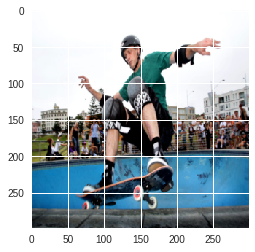

In [29]:
plt.imshow(img)

In [30]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


a man riding a skateboard on a skateboard .
a man in a skateboard is doing a trick .
a man on a skateboard in the air .
a man in a black shirt and white shirt and white shirt and white photo
a man is riding a skateboard on a skateboard .
a man in a red shirt is riding a skateboard .
a man riding a skateboard down a skateboard .
a man riding a skateboard on a skateboard .
a man in a red shirt and a skateboard .
a man riding a skateboard in the air .


--2018-11-19 17:58:27--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.07s   

2018-11-19 17:58:28 (1.37 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


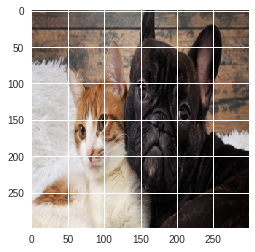

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat sitting on a bed with a dog .
a cat is sitting on a bed with a dog .
a cat laying on a bed with a dog .
a cat sitting on a bed with a dog .
a cat laying on a bed with a dog .
a cat sitting on a bed with a black and white cat .
a cat sitting on a bed with a dog .
a cat laying on the floor of a bed .


In [31]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [0]:
#apply your network on image sample you found
#
#

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


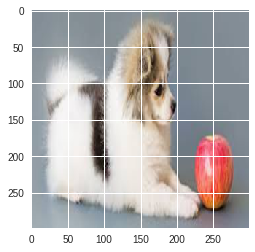

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


a cat is sitting on a wooden bench .
a cat is sitting on a wooden table .
a cat is sitting on a white plate with a dog .
a cat is sitting on the side of a wooden table .
a cat is sitting on a wooden table .
a cat is sitting on a wooden bench
a cat is sitting on a wooden table .
a cat is sitting on a wooden table .
a cat is sitting on a wooden table .
a cat is sitting on a wooden table .


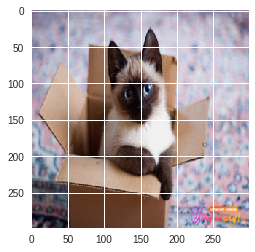

a cat sitting on a table with a small white dog .
a cat sitting on top of a wooden table .
a cat sitting on a wooden bench next to a window .
a cat sitting on a wooden table with a red and white dog .
a cat sitting on a wooden table with a window .
a cat is sitting on a wooden table .
a cat sitting on top of a wooden table .
a cat is sitting on a table with a window .
a cat sitting on top of a wooden table .
a cat sitting on a table with a large window .


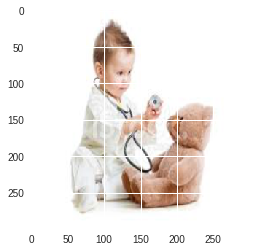

a young girl is holding a teddy bear in a black .
a young boy holding a teddy bear in a bear .
a young girl is holding a teddy bear
a little girl is standing in a white shirt .
a young boy holding a teddy bear in the background
a young girl is holding a teddy bear in the background .
a young girl is holding a teddy bear in a field .
a young boy holding a cell phone in the grass .
a boy is holding a teddy bear in a black .
a woman holding a teddy bear in the grass .


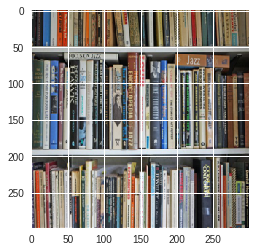

a group of people standing in a field
a man in a black shirt and white cat .
a group of people standing on a table with a large blue and a large blue and white and a desk .
a group of people are standing in the water .
a group of people sitting on a table in the water .
a couple of people standing on a table .
a man in a black shirt and white shirt and a dog in the background .
a man is holding a dog on a bed .
a group of people standing in a field .
a man in a black shirt and white shirt and a dog .


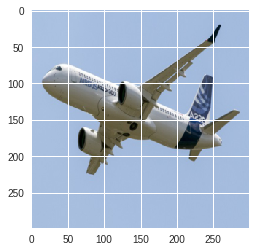

a plane is flying in the air .
a plane is flying in the air .
a plane is flying in the air .
a plane is flying in the air
a plane is flying in the sky .
a plane flying in the air at the runway .
a plane is flying in the sky .
a plane is flying in the sky .
a plane is flying in the sky .
a plane is flying in the sky .


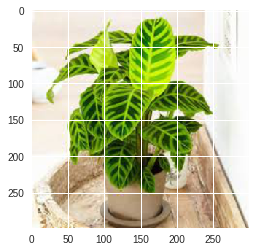

a vase of flowers sitting on a table with a white vase .
a white vase with a large vase of flowers in it .
a close up of a small table with a #UNK# of fruit
a vase with a vase of flowers in a vase .
a vase with a vase of flowers and a cup of flowers .
a white vase with a vase of flowers in it .
a vase with a white and white vase in a vase
a vase with a vase of flowers and a vase
a vase of a vase of flowers on a table .
a white vase with a vase of flowers in it


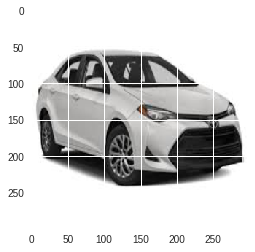

a small white truck is parked in the background
a large truck is parked on a road .
a red truck is parked on the side of a road .
a black and white photo of a yellow truck .
a red truck is parked next to a truck .
a red truck is parked next to a car .
a red fire hydrant in the middle of a city street .
a red truck is parked next to a car .
a red truck is parked next to a car .
a red truck is parked in the middle of a street .


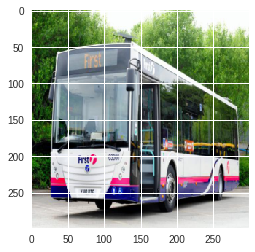

a bus driving down a street with a bus
a bus is parked on the side of a street .
a bus is parked on a street with a bus .
a bus driving down a street next to a building .
a bus is parked on a street in the background .
a bus is parked in the middle of a city street .
a bus driving down a street with a large building .
a bus driving down a street with a bus .
a bus that is parked in the middle of a city street .
a bus is parked on the street in the background .


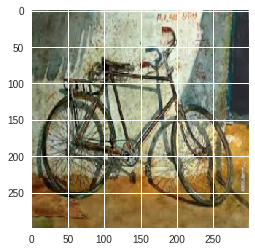

a person riding a motorcycle on a road .
a man riding a motorcycle in a parking lot .
a man riding a motorcycle on a motorcycle .
a woman is riding a motorcycle in the grass .
a man is riding a motorcycle on a street .
a person riding a horse on a road .
a man riding a motorcycle in a parking lot .
a man is riding a motorcycle in the air .
a man riding a skateboard in the middle of a street .
a man riding a motorcycle on a street in the background .


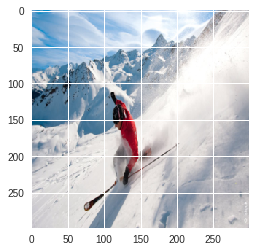

a man riding a wave in the ocean .
a man riding a wave on a surfboard in the water .
a person is riding a surfboard on a surfboard .
a person is riding a wave on a surfboard .
a man is riding a wave on a surfboard .
a person on a surfboard on a wave .
a man riding a wave on a surfboard in the water .
a man riding a wave on a surfboard in the water .
a person riding a wave on a surfboard .
a person riding a wave on a snowy mountain .


In [33]:
for i in range(10):
    img = plt.imread(f'data/{i}.jpg')
    img = imresize(img, (299, 299)).astype('float32') / 255.
    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563